Code link for 2D optimization: http://blog.sws9f.org/computer-vision/2017/09/07/colorization-using-optimization-python.html

Code link for Gatys Style Transfer: https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

In [1]:
import os
import sys
import tqdm
import copy
import torch
import colorsys
import logging

import numpy as np
import torch.nn as nn
import skimage.io as io
import scipy.misc as smi
import SimpleITK as sitk
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
from pyamg import solve
from skimage import exposure
from torch.autograd import Variable
from skimage.transform import resize
from skimage import color, img_as_float
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix, csr_matrix

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
imsize = (256,256) if torch.cuda.is_available() else (32,32)

In [3]:
OUTPUT_DIR = './New_Results_WACV/temp/'
if(not os.path.exists(OUTPUT_DIR)):
    os.makedirs(OUTPUT_DIR)

np.set_printoptions(precision=8, suppress=True)

# Inputs

In [4]:
path_volume = './generated_test16.mhd'
path_style_image = './style_images/style_image_4.png'

# Gatys Neural Style Transfer Code

#### Image Loader

In [5]:
loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    img = np.array(image)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float), img.shape

unloader = transforms.ToPILImage()  # reconvert into PIL image

def imsave(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    return np.array(image)

#### Loss Functions

In [6]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
    
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input
    
class RGB2YUV(nn.Module):
    def __init__(self):
        super(RGB2YUV, self).__init__()
    
    def forward(self, input_img):
        yuv = Variable(torch.zeros_like(input_img)) 
        yuv[:,0,:,:] = input_img[:,0,:,:]*0.2999+ (0.587 * input_img[:,1,:,:])  + 0.114 * input_img[:,2,:,:] 
        yuv[:,1,:,:] = input_img[:,0,:,:]*(-0.14713)+ (-0.28886 * input_img[:,1,:,:])  + 0.436 * input_img[:,2,:,:] 
        yuv[:,2,:,:] = input_img[:,0,:,:]*0.615 + (-0.51499 * input_img[:,1,:,:])  + (-0.10001 * input_img[:,2,:,:] )
        
        return yuv    
    
class TVLoss(nn.Module):
    def __init__(self):
        super(TVLoss, self).__init__()

    def forward(self, input_img):
        return torch.sum(torch.abs(input_img[:,:,:,:-1] - input_img[:,:,:,1:])) + torch.sum(torch.abs(input_img[:,:,:-1,:] - input_img[:,:,1:,:]))

#### Initialize convolution layers

In [7]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std
    
content_layers_default = ['conv_{}'.format(i) for i in range(1,8)]
style_layers_default = ['conv_{}'.format(i) for i in range(1,8)]
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

#### Optimizer

In [8]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()], lr=1.0e0)
    return optimizer

In [9]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num=0, num_steps=300,
                       style_weight=1000000, content_weight=1, tv_weight=2e-2, diff_weight=1e-1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)
    rgb2yuv = RGB2YUV().to(device)
    criterion_tv = TVLoss().to(device)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            
            rgb2yuv_img = rgb2yuv(input_img)
            tv_loss = tv_weight * (torch.sum(torch.abs(rgb2yuv_img[:, 1:3 , :, :-1] - rgb2yuv_img[:, 1:3 ,:, 1:]))\
                                   + torch.sum(torch.abs(rgb2yuv_img[:, 1:3 , :-1, :] - rgb2yuv_img[:, 1:3 , 1:,:])))
            tv_loss_content_img = tv_weight * criterion_tv(content_img)
            diff_loss = torch.abs(tv_loss - tv_loss_content_img)
            total_loss = tv_loss + diff_weight * diff_loss
            
            total_loss.backward(retain_graph=True)
            
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}, TV Loss:{:.4f} Diff Loss: {:.4f} '.format(
                    style_score.item(), content_score.item(), tv_loss.item(), diff_loss.item()))
                print()
                output_img = resize(imsave(input_img), input_img.shape[2:])
#                 io.imsave(OUTPUT_DIR + 'test_{}_{}.png'.format(num, run), output_img)

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

# Preprocessing

In [10]:
def read_numpy_volume(path):
    vol = sitk.ReadImage(path)
    np_vol = sitk.GetArrayFromImage(vol)

    # np_vol = (np_vol - np.min(np_vol)) / (np.max(np_vol) - np.min(np_vol))

    return np_vol

def to_grey(np_vol):
    if(len(np_vol.shape)==4):
        h,ww,l,c = np_vol.shape
    else:
        h,ww,l = np_vol.shape
    
    grey = np.zeros((h,ww,l,3))
    
    for i in range(h):
        if(len(np_vol.shape)==4):
            grey_img = color.rgb2gray(np_vol[i,:,:])
        else:
            grey_img = np_vol[i,:,:]
        
        if(np.max(grey_img)>1):
            grey_img = grey_img / 255.0
        
        grey[i,:,:,0], grey[i,:,:,1], grey[i,:,:,2] = grey_img, grey_img, grey_img
    
    return grey

def generate_hints(grey_vol, color_vol, offset=10, axis='x', save=True):
    h,ww,l,c = grey_vol.shape
    out_vol = np.zeros((h,ww,l,c))
    out_vol = grey_vol.copy()
    
    cnn = models.vgg19(pretrained=True).features.to(device).eval()

    cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

    slices = []
    if(axis=='x'):
        num_hints = h // offset
        for i in range(num_hints):
            slices.append(grey_vol[i*offset,:,:,:])
    elif(axis=='y'):
        num_hints = ww // offset
        for i in range(num_hints):
            slices.append(grey_vol[:,i*offset,:,:])
    else:
        num_hints = l // offset
        for i in range(num_hints):
            slices.append(grey_vol[:,:,i*offset,:])

    for i in tqdm.trange(num_hints):
        curr_slices = slices[i]
        
        if save:
            io.imsave(OUTPUT_DIR+'/l_channel.png', curr_slices)
            io.imsave(OUTPUT_DIR+'/l_channel_{}.png'.format(i), curr_slices)

        content_img, content_shape = image_loader(OUTPUT_DIR+'l_channel.png')
        style_img, _ = image_loader(path_style_image)
        
        input_img = content_img.clone()

        output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                                    content_img, style_img, input_img, num=i, num_steps=500, 
                                content_weight=2.5, tv_weight=2e-1, diff_weight=0)

        output_img = resize(imsave(output), content_shape[:2])
        io.imsave(OUTPUT_DIR+'test_{}.png'.format(i), output_img)

        if(axis=='x'):
            out_vol[i*offset,:,:,:] = img_as_float(io.imread(OUTPUT_DIR+'test_{}.png'.format(i)))
        elif(axis=='y'):
            out_vol[:,i*offset,:,:] = img_as_float(io.imread(OUTPUT_DIR+'test_{}.png'.format(i)))
        else:
            out_vol[:,:,i*offset,:] = img_as_float(io.imread(OUTPUT_DIR+'test_{}.png'.format(i)))
    
    return out_vol

# Optimization Code

In [11]:
class WindowNeighbor:
    def __init__(self, width, center, pic):
        # center is a list of [row, col, Y_intensity]
        self.center = [center[0], center[1], center[2], pic[center][0]]
        self.width = width
        self.neighbors = None
        self.find_neighbors(pic)
        self.mean = None
        self.var = None

    def find_neighbors(self, pic):
        self.neighbors = []
        ix_r_min = max(0, self.center[0] - self.width)
        ix_r_max = min(pic.shape[0], self.center[0] + self.width + 1)
        ix_c_min = max(0, self.center[1] - self.width)
        ix_c_max = min(pic.shape[1], self.center[1] + self.width + 1)
        ix_l_min = max(0, self.center[2] - self.width)
        ix_l_max = min(pic.shape[2], self.center[2] + self.width + 1)
        for r in range(ix_r_min, ix_r_max):
            for c in range(ix_c_min, ix_c_max):
                for l in range(ix_l_min, ix_l_max):
                    if r == self.center[0] and c == self.center[1] and l ==self.center[2]:
                        continue
                    self.neighbors.append([r,c,l,pic[r,c,l,0]])

    def __str__(self):
        return 'windows c=(%d, %d, %f) size: %d' % (self.center[0], self.center[1], self.center[2], len(self.neighbors))

# affinity functions, calculate weights of pixels in a window by their intensity.
def affinity_a(w):
    nbs = np.array(w.neighbors)
    sY = nbs[:,3]
    cY = w.center[3]
    diff = sY - cY
    sig = np.var(np.append(sY, cY))
    if sig < 1e-6:
        sig = 1e-6  
    wrs = np.exp(- np.power(diff,2) / (sig * 2.0))
    wrs = - wrs / np.sum(wrs)
    nbs[:,3] = wrs
    return nbs

# translate (row,col) to/from sequential number
def to_seq(i,j,k, grey_vol):
    index = np.ravel_multi_index([int(i),int(j),int(k)], grey_vol[:,:,:,0].shape)
    return index

def fr_seq(seq, rows):
    r = seq % rows
    c = int((seq - r) / rows)
    return (r, c)

# combine 3 channels of YUV to a RGB photo: n x n x n x 3 array
def yuv_channels_to_rgb(cY,cU,cV, h, ww, l):
    ansRGB = [colorsys.yiq_to_rgb(cY[i],cU[i],cV[i]) for i in range(len(cY))]
    ansRGB = np.array(ansRGB)
    pic_ansRGB = np.zeros((h, ww, l, 3))
    pic_ansRGB[:,:,:,0] = ansRGB[:,0].reshape(h, ww, l, order='C')
    pic_ansRGB[:,:,:,1] = ansRGB[:,1].reshape(h, ww, l, order='C')
    pic_ansRGB[:,:,:,2] = ansRGB[:,2].reshape(h, ww, l, order='C')
    return pic_ansRGB

### Run preprocessing

In [12]:
off = 5
ax = 'x'

In [13]:
color_vol = read_numpy_volume(path_volume)

grey_vol = to_grey(read_numpy_volume(path_volume))

print('The shape of input volume = {}'.format(grey_vol.shape))

g_vol = sitk.GetImageFromArray(grey_vol)
g_vol = sitk.WriteImage(g_vol, OUTPUT_DIR+'g.mhd')

hints_vol = generate_hints(grey_vol, color_vol, offset=off, axis=ax)
h,ww,l,c = grey_vol.shape

The shape of input volume = (128, 128, 88, 3)


  0%|          | 0/25 [00:00<?, ?it/s]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/home/aradhya/anaconda3/envs/torchenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/aradhya/anaconda3/envs/torchenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Building the style transfer model..
Optimizing..


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [50]:
Style Loss : 1009.326538 Content Loss: 318.865448, TV Loss:156.6232 Diff Loss: 30.3274 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [100]:
Style Loss : 350.189545 Content Loss: 332.863586, TV Loss:123.7552 Diff Loss: 63.1954 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [150]:
Style Loss : 141.516342 Content Loss: 335.890472, TV Loss:93.9158 Diff Loss: 93.0348 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [200]:
Style Loss : 80.109200 Content Loss: 335.891174, TV Loss:78.4652 Diff Loss: 108.4854 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [250]:
Style Loss : 57.996300 Content Loss: 335.805206, TV Loss:71.4842 Diff Loss: 115.4664 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [300]:
Style Loss : 47.337326 Content Loss: 335.459412, TV Loss:67.0282 Diff Loss: 119.9224 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [350]:
Style Loss : 42.119808 Content Loss: 335.090454, TV Loss:63.3347 Diff Loss: 123.6158 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [400]:
Style Loss : 39.094772 Content Loss: 334.625885, TV Loss:60.8635 Diff Loss: 126.0871 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [450]:
Style Loss : 37.095005 Content Loss: 334.419861, TV Loss:59.1661 Diff Loss: 127.7845 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [500]:
Style Loss : 35.710194 Content Loss: 334.123566, TV Loss:57.5394 Diff Loss: 129.4112 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  4%|▍         | 1/25 [00:22<09:00, 22.50s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Building the style transfer model..
Optimizing..


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [50]:
Style Loss : 372.475983 Content Loss: 259.507629, TV Loss:106.1027 Diff Loss: 343.7090 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [100]:
Style Loss : 211.635056 Content Loss: 252.574402, TV Loss:73.9599 Diff Loss: 375.8518 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [150]:
Style Loss : 159.819443 Content Loss: 249.035110, TV Loss:66.7940 Diff Loss: 383.0177 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [200]:
Style Loss : 130.217850 Content Loss: 248.457397, TV Loss:63.0309 Diff Loss: 386.7809 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [250]:
Style Loss : 114.920410 Content Loss: 247.971375, TV Loss:60.8215 Diff Loss: 388.9903 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [300]:
Style Loss : 105.477913 Content Loss: 247.498383, TV Loss:59.4635 Diff Loss: 390.3482 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [350]:
Style Loss : 99.247711 Content Loss: 246.900085, TV Loss:58.4759 Diff Loss: 391.3359 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [400]:
Style Loss : 94.176620 Content Loss: 246.590195, TV Loss:57.7253 Diff Loss: 392.0865 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [450]:
Style Loss : 90.188797 Content Loss: 246.178436, TV Loss:56.9502 Diff Loss: 392.8616 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [500]:
Style Loss : 86.850708 Content Loss: 245.821304, TV Loss:56.2864 Diff Loss: 393.5253 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  8%|▊         | 2/25 [00:44<08:31, 22.24s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Building the style transfer model..
Optimizing..


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [50]:
Style Loss : 280.065674 Content Loss: 232.294998, TV Loss:97.0013 Diff Loss: 478.3069 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [100]:
Style Loss : 177.152740 Content Loss: 224.210632, TV Loss:71.4570 Diff Loss: 503.8513 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [150]:
Style Loss : 134.211380 Content Loss: 221.338882, TV Loss:65.8595 Diff Loss: 509.4488 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [200]:
Style Loss : 109.199783 Content Loss: 220.060654, TV Loss:62.9284 Diff Loss: 512.3799 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [250]:
Style Loss : 96.821182 Content Loss: 219.144714, TV Loss:60.8188 Diff Loss: 514.4895 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [300]:
Style Loss : 89.859543 Content Loss: 218.224487, TV Loss:59.3729 Diff Loss: 515.9354 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [350]:
Style Loss : 85.190247 Content Loss: 217.658508, TV Loss:58.3038 Diff Loss: 517.0045 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [400]:
Style Loss : 81.899727 Content Loss: 217.145462, TV Loss:57.4464 Diff Loss: 517.8618 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [450]:
Style Loss : 79.410606 Content Loss: 216.703629, TV Loss:56.7603 Diff Loss: 518.5480 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [500]:
Style Loss : 77.322792 Content Loss: 216.383148, TV Loss:56.2262 Diff Loss: 519.0821 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 12%|█▏        | 3/25 [01:05<08:05, 22.06s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Building the style transfer model..
Optimizing..


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [50]:
Style Loss : 225.099060 Content Loss: 207.426086, TV Loss:93.7032 Diff Loss: 604.0875 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [100]:
Style Loss : 144.956451 Content Loss: 200.768524, TV Loss:69.7123 Diff Loss: 628.0784 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [150]:
Style Loss : 110.042847 Content Loss: 198.226868, TV Loss:63.9864 Diff Loss: 633.8042 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [200]:
Style Loss : 90.084114 Content Loss: 197.192719, TV Loss:61.2601 Diff Loss: 636.5305 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [250]:
Style Loss : 80.087166 Content Loss: 196.417206, TV Loss:59.5431 Diff Loss: 638.2475 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [300]:
Style Loss : 74.348343 Content Loss: 195.730194, TV Loss:58.2821 Diff Loss: 639.5085 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [350]:
Style Loss : 70.536392 Content Loss: 195.252060, TV Loss:57.3442 Diff Loss: 640.4464 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [400]:
Style Loss : 67.913338 Content Loss: 194.826752, TV Loss:56.5855 Diff Loss: 641.2052 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [450]:
Style Loss : 65.902977 Content Loss: 194.469681, TV Loss:55.9396 Diff Loss: 641.8511 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [500]:
Style Loss : 64.411133 Content Loss: 194.157227, TV Loss:55.3245 Diff Loss: 642.4662 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 16%|█▌        | 4/25 [01:27<07:41, 21.96s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Building the style transfer model..
Optimizing..


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [50]:
Style Loss : 176.197968 Content Loss: 198.449539, TV Loss:91.3191 Diff Loss: 685.0245 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [100]:
Style Loss : 117.891396 Content Loss: 191.296310, TV Loss:69.0780 Diff Loss: 707.2656 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [150]:
Style Loss : 88.566605 Content Loss: 188.718903, TV Loss:63.6191 Diff Loss: 712.7244 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [200]:
Style Loss : 73.112984 Content Loss: 187.484100, TV Loss:60.7852 Diff Loss: 715.5583 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [250]:
Style Loss : 65.389656 Content Loss: 186.573669, TV Loss:58.9887 Diff Loss: 717.3548 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [300]:
Style Loss : 60.878761 Content Loss: 185.920731, TV Loss:57.6475 Diff Loss: 718.6961 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [350]:
Style Loss : 58.051620 Content Loss: 185.367035, TV Loss:56.5652 Diff Loss: 719.7784 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [400]:
Style Loss : 56.157509 Content Loss: 184.854126, TV Loss:55.8031 Diff Loss: 720.5405 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [450]:
Style Loss : 54.708160 Content Loss: 184.430145, TV Loss:55.1417 Diff Loss: 721.2019 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [500]:
Style Loss : 53.588779 Content Loss: 184.098328, TV Loss:54.5981 Diff Loss: 721.7455 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 20%|██        | 5/25 [01:51<07:32, 22.63s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Building the style transfer model..
Optimizing..


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [50]:
Style Loss : 162.985123 Content Loss: 198.141357, TV Loss:91.8355 Diff Loss: 675.2728 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [100]:
Style Loss : 110.621201 Content Loss: 190.235977, TV Loss:68.6999 Diff Loss: 698.4085 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [150]:
Style Loss : 83.967415 Content Loss: 187.649689, TV Loss:63.0500 Diff Loss: 704.0583 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [200]:
Style Loss : 69.595627 Content Loss: 186.073730, TV Loss:60.1062 Diff Loss: 707.0021 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [250]:
Style Loss : 62.349129 Content Loss: 185.093872, TV Loss:58.2875 Diff Loss: 708.8208 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [300]:
Style Loss : 58.319664 Content Loss: 184.221130, TV Loss:57.0609 Diff Loss: 710.0474 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [350]:
Style Loss : 55.720230 Content Loss: 183.561539, TV Loss:56.0896 Diff Loss: 711.0187 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [400]:
Style Loss : 53.761997 Content Loss: 183.091278, TV Loss:55.3413 Diff Loss: 711.7670 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [450]:
Style Loss : 52.376316 Content Loss: 182.644974, TV Loss:54.6816 Diff Loss: 712.4267 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [500]:
Style Loss : 51.311695 Content Loss: 182.278107, TV Loss:54.1066 Diff Loss: 713.0017 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 24%|██▍       | 6/25 [02:25<08:14, 26.04s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Building the style transfer model..
Optimizing..


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [50]:
Style Loss : 159.839691 Content Loss: 197.503998, TV Loss:91.2781 Diff Loss: 685.5831 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [100]:
Style Loss : 107.337631 Content Loss: 190.302887, TV Loss:69.1101 Diff Loss: 707.7512 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [150]:
Style Loss : 81.533569 Content Loss: 187.734436, TV Loss:63.5120 Diff Loss: 713.3492 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [200]:
Style Loss : 68.042076 Content Loss: 186.284058, TV Loss:60.7980 Diff Loss: 716.0633 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [250]:
Style Loss : 61.269894 Content Loss: 185.427002, TV Loss:58.9367 Diff Loss: 717.9246 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [300]:
Style Loss : 57.236362 Content Loss: 184.724823, TV Loss:57.7742 Diff Loss: 719.0870 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [350]:
Style Loss : 54.761642 Content Loss: 184.032227, TV Loss:56.8246 Diff Loss: 720.0367 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [400]:
Style Loss : 52.995770 Content Loss: 183.463669, TV Loss:56.1085 Diff Loss: 720.7527 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [450]:
Style Loss : 51.573292 Content Loss: 183.011505, TV Loss:55.5037 Diff Loss: 721.3576 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [500]:
Style Loss : 50.483978 Content Loss: 182.642792, TV Loss:54.9523 Diff Loss: 721.9089 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 28%|██▊       | 7/25 [03:02<08:49, 29.40s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Building the style transfer model..
Optimizing..


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [50]:
Style Loss : 151.459366 Content Loss: 187.272949, TV Loss:90.0285 Diff Loss: 740.1621 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [100]:
Style Loss : 102.501190 Content Loss: 180.174484, TV Loss:68.2389 Diff Loss: 761.9518 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [150]:
Style Loss : 77.767456 Content Loss: 177.808304, TV Loss:62.8579 Diff Loss: 767.3327 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [200]:
Style Loss : 65.351402 Content Loss: 176.405869, TV Loss:60.2188 Diff Loss: 769.9718 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [250]:
Style Loss : 59.029236 Content Loss: 175.446548, TV Loss:58.4647 Diff Loss: 771.7260 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [300]:
Style Loss : 55.433800 Content Loss: 174.719208, TV Loss:57.2016 Diff Loss: 772.9890 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [350]:
Style Loss : 53.107002 Content Loss: 174.143921, TV Loss:56.3202 Diff Loss: 773.8704 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [400]:
Style Loss : 51.403618 Content Loss: 173.705780, TV Loss:55.5937 Diff Loss: 774.5969 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [450]:
Style Loss : 50.042530 Content Loss: 173.369293, TV Loss:54.9730 Diff Loss: 775.2176 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [500]:
Style Loss : 49.071480 Content Loss: 173.067535, TV Loss:54.4641 Diff Loss: 775.7264 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 32%|███▏      | 8/25 [03:47<09:35, 33.84s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Building the style transfer model..
Optimizing..


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [50]:
Style Loss : 143.030594 Content Loss: 183.433228, TV Loss:87.5911 Diff Loss: 734.4348 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [100]:
Style Loss : 98.700912 Content Loss: 176.690826, TV Loss:67.7079 Diff Loss: 754.3180 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [150]:
Style Loss : 74.052635 Content Loss: 174.429596, TV Loss:62.4145 Diff Loss: 759.6114 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [200]:
Style Loss : 62.545464 Content Loss: 173.216583, TV Loss:59.6408 Diff Loss: 762.3850 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [250]:
Style Loss : 56.679230 Content Loss: 172.490326, TV Loss:57.9538 Diff Loss: 764.0721 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [300]:
Style Loss : 53.339165 Content Loss: 171.785522, TV Loss:56.7385 Diff Loss: 765.2874 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [350]:
Style Loss : 51.134083 Content Loss: 171.251602, TV Loss:55.8263 Diff Loss: 766.1996 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [400]:
Style Loss : 49.730293 Content Loss: 170.675629, TV Loss:55.0640 Diff Loss: 766.9619 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [450]:
Style Loss : 48.560104 Content Loss: 170.265503, TV Loss:54.4569 Diff Loss: 767.5690 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [500]:
Style Loss : 47.553360 Content Loss: 169.995712, TV Loss:53.8923 Diff Loss: 768.1335 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 36%|███▌      | 9/25 [04:34<10:07, 37.99s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Building the style transfer model..
Optimizing..


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [50]:
Style Loss : 140.000046 Content Loss: 179.332581, TV Loss:90.4764 Diff Loss: 718.5236 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [100]:
Style Loss : 96.784271 Content Loss: 171.664154, TV Loss:68.0879 Diff Loss: 740.9122 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [150]:
Style Loss : 73.215332 Content Loss: 169.505936, TV Loss:62.5357 Diff Loss: 746.4644 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [200]:
Style Loss : 62.186466 Content Loss: 168.170319, TV Loss:59.7522 Diff Loss: 749.2478 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [250]:
Style Loss : 56.563812 Content Loss: 167.267914, TV Loss:58.1351 Diff Loss: 750.8649 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [300]:
Style Loss : 53.152538 Content Loss: 166.645721, TV Loss:57.0318 Diff Loss: 751.9682 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [350]:
Style Loss : 50.891735 Content Loss: 166.033966, TV Loss:56.1877 Diff Loss: 752.8123 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [400]:
Style Loss : 49.256310 Content Loss: 165.555969, TV Loss:55.4639 Diff Loss: 753.5361 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [450]:
Style Loss : 47.999527 Content Loss: 165.247253, TV Loss:54.8163 Diff Loss: 754.1837 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [500]:
Style Loss : 47.033516 Content Loss: 164.944687, TV Loss:54.2972 Diff Loss: 754.7028 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 40%|████      | 10/25 [05:23<10:19, 41.29s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Building the style transfer model..
Optimizing..


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [50]:
Style Loss : 140.302139 Content Loss: 177.293243, TV Loss:90.1826 Diff Loss: 733.8386 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [100]:
Style Loss : 96.961060 Content Loss: 169.304565, TV Loss:68.3135 Diff Loss: 755.7077 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [150]:
Style Loss : 73.975960 Content Loss: 166.871185, TV Loss:62.8372 Diff Loss: 761.1840 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [200]:
Style Loss : 62.331448 Content Loss: 165.821152, TV Loss:60.0782 Diff Loss: 763.9430 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [250]:
Style Loss : 56.559452 Content Loss: 165.057251, TV Loss:58.3959 Diff Loss: 765.6253 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [300]:
Style Loss : 53.083473 Content Loss: 164.391953, TV Loss:57.2454 Diff Loss: 766.7758 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [350]:
Style Loss : 50.790539 Content Loss: 163.871399, TV Loss:56.3207 Diff Loss: 767.7005 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [400]:
Style Loss : 49.258217 Content Loss: 163.344818, TV Loss:55.4924 Diff Loss: 768.5288 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [450]:
Style Loss : 48.095192 Content Loss: 162.860626, TV Loss:54.8652 Diff Loss: 769.1560 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [500]:
Style Loss : 47.152996 Content Loss: 162.477905, TV Loss:54.3351 Diff Loss: 769.6860 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 44%|████▍     | 11/25 [06:17<10:29, 44.97s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Building the style transfer model..
Optimizing..


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [50]:
Style Loss : 145.677368 Content Loss: 176.005585, TV Loss:88.9241 Diff Loss: 713.2642 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [100]:
Style Loss : 100.001488 Content Loss: 169.439972, TV Loss:68.5951 Diff Loss: 733.5933 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [150]:
Style Loss : 75.442520 Content Loss: 167.083008, TV Loss:63.2749 Diff Loss: 738.9133 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [200]:
Style Loss : 63.590900 Content Loss: 165.959198, TV Loss:60.5127 Diff Loss: 741.6755 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [250]:
Style Loss : 57.609756 Content Loss: 165.020828, TV Loss:58.7525 Diff Loss: 743.4358 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [300]:
Style Loss : 54.096638 Content Loss: 164.312515, TV Loss:57.5282 Diff Loss: 744.6601 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [350]:
Style Loss : 51.699169 Content Loss: 163.746307, TV Loss:56.5659 Diff Loss: 745.6224 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [400]:
Style Loss : 50.000969 Content Loss: 163.279449, TV Loss:55.7855 Diff Loss: 746.4028 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [450]:
Style Loss : 48.708492 Content Loss: 162.903122, TV Loss:55.1038 Diff Loss: 747.0845 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [500]:
Style Loss : 47.731964 Content Loss: 162.538528, TV Loss:54.5037 Diff Loss: 747.6846 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 48%|████▊     | 12/25 [07:08<10:10, 46.95s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Building the style transfer model..
Optimizing..


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [50]:
Style Loss : 145.998077 Content Loss: 172.071091, TV Loss:89.2531 Diff Loss: 705.1611 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [100]:
Style Loss : 101.742691 Content Loss: 164.647812, TV Loss:68.5387 Diff Loss: 725.8755 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [150]:
Style Loss : 77.429420 Content Loss: 162.261353, TV Loss:63.2322 Diff Loss: 731.1819 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [200]:
Style Loss : 65.006371 Content Loss: 161.173630, TV Loss:60.3994 Diff Loss: 734.0148 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [250]:
Style Loss : 58.704010 Content Loss: 160.363693, TV Loss:58.8805 Diff Loss: 735.5337 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [300]:
Style Loss : 55.151676 Content Loss: 159.708069, TV Loss:57.7237 Diff Loss: 736.6905 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [350]:
Style Loss : 52.635986 Content Loss: 159.247177, TV Loss:56.8521 Diff Loss: 737.5620 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [400]:
Style Loss : 50.739758 Content Loss: 158.916290, TV Loss:56.1300 Diff Loss: 738.2841 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [450]:
Style Loss : 49.408150 Content Loss: 158.536530, TV Loss:55.5516 Diff Loss: 738.8626 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [500]:
Style Loss : 48.338032 Content Loss: 158.253616, TV Loss:55.0618 Diff Loss: 739.3524 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 52%|█████▏    | 13/25 [08:01<09:43, 48.63s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Building the style transfer model..
Optimizing..


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [50]:
Style Loss : 144.696472 Content Loss: 172.541260, TV Loss:90.5754 Diff Loss: 699.5730 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [100]:
Style Loss : 99.179497 Content Loss: 165.609375, TV Loss:69.3368 Diff Loss: 720.8115 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [150]:
Style Loss : 76.153069 Content Loss: 163.333893, TV Loss:63.8605 Diff Loss: 726.2879 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [200]:
Style Loss : 64.124138 Content Loss: 162.102936, TV Loss:60.9838 Diff Loss: 729.1646 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [250]:
Style Loss : 58.127682 Content Loss: 161.284729, TV Loss:59.3315 Diff Loss: 730.8169 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [300]:
Style Loss : 54.456871 Content Loss: 160.641754, TV Loss:58.1865 Diff Loss: 731.9619 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [350]:
Style Loss : 51.989033 Content Loss: 160.123718, TV Loss:57.3132 Diff Loss: 732.8352 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [400]:
Style Loss : 50.229935 Content Loss: 159.658707, TV Loss:56.6051 Diff Loss: 733.5433 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [450]:
Style Loss : 48.885567 Content Loss: 159.262268, TV Loss:56.0218 Diff Loss: 734.1266 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [500]:
Style Loss : 47.796364 Content Loss: 158.992645, TV Loss:55.4891 Diff Loss: 734.6593 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 56%|█████▌    | 14/25 [08:57<09:18, 50.74s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Building the style transfer model..
Optimizing..


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [50]:
Style Loss : 141.691299 Content Loss: 169.487457, TV Loss:89.2398 Diff Loss: 739.1108 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [100]:
Style Loss : 97.808258 Content Loss: 162.868744, TV Loss:68.5616 Diff Loss: 759.7889 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [150]:
Style Loss : 73.956528 Content Loss: 160.704803, TV Loss:63.2737 Diff Loss: 765.0769 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [200]:
Style Loss : 62.099113 Content Loss: 159.703308, TV Loss:60.4909 Diff Loss: 767.8597 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [250]:
Style Loss : 56.551727 Content Loss: 158.942612, TV Loss:58.6835 Diff Loss: 769.6671 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [300]:
Style Loss : 53.059956 Content Loss: 158.308792, TV Loss:57.4732 Diff Loss: 770.8774 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [350]:
Style Loss : 50.696442 Content Loss: 157.835220, TV Loss:56.5529 Diff Loss: 771.7976 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [400]:
Style Loss : 48.995453 Content Loss: 157.441116, TV Loss:55.8502 Diff Loss: 772.5004 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [450]:
Style Loss : 47.831657 Content Loss: 157.057709, TV Loss:55.1748 Diff Loss: 773.1758 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [500]:
Style Loss : 46.858498 Content Loss: 156.763443, TV Loss:54.6263 Diff Loss: 773.7243 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 60%|██████    | 15/25 [09:52<08:42, 52.26s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Building the style transfer model..
Optimizing..


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [50]:
Style Loss : 143.904892 Content Loss: 170.770905, TV Loss:89.2036 Diff Loss: 727.9211 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [100]:
Style Loss : 98.747597 Content Loss: 164.413147, TV Loss:68.9742 Diff Loss: 748.1505 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [150]:
Style Loss : 74.833191 Content Loss: 162.382339, TV Loss:63.5430 Diff Loss: 753.5817 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [200]:
Style Loss : 62.975784 Content Loss: 161.321716, TV Loss:60.4925 Diff Loss: 756.6323 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [250]:
Style Loss : 57.083736 Content Loss: 160.477448, TV Loss:58.7172 Diff Loss: 758.4075 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [300]:
Style Loss : 53.481228 Content Loss: 159.927826, TV Loss:57.5475 Diff Loss: 759.5771 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [350]:
Style Loss : 51.064007 Content Loss: 159.453339, TV Loss:56.6148 Diff Loss: 760.5099 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [400]:
Style Loss : 49.406586 Content Loss: 158.989212, TV Loss:55.8295 Diff Loss: 761.2952 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [450]:
Style Loss : 48.137424 Content Loss: 158.622879, TV Loss:55.2448 Diff Loss: 761.8799 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [500]:
Style Loss : 47.092812 Content Loss: 158.336182, TV Loss:54.7200 Diff Loss: 762.4047 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 64%|██████▍   | 16/25 [10:50<08:05, 53.99s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Building the style transfer model..
Optimizing..


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [50]:
Style Loss : 150.686569 Content Loss: 172.847992, TV Loss:89.6867 Diff Loss: 764.3274 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [100]:
Style Loss : 101.870438 Content Loss: 166.165237, TV Loss:68.6319 Diff Loss: 785.3822 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [150]:
Style Loss : 77.683014 Content Loss: 163.936127, TV Loss:63.2859 Diff Loss: 790.7282 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [200]:
Style Loss : 65.662811 Content Loss: 162.942947, TV Loss:60.5597 Diff Loss: 793.4543 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [250]:
Style Loss : 59.477249 Content Loss: 162.236023, TV Loss:58.8730 Diff Loss: 795.1412 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [300]:
Style Loss : 55.767723 Content Loss: 161.642838, TV Loss:57.6599 Diff Loss: 796.3542 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [350]:
Style Loss : 53.306961 Content Loss: 161.229889, TV Loss:56.7457 Diff Loss: 797.2684 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [400]:
Style Loss : 51.684223 Content Loss: 160.775146, TV Loss:56.0142 Diff Loss: 797.9999 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [450]:
Style Loss : 50.485802 Content Loss: 160.402527, TV Loss:55.3888 Diff Loss: 798.6252 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [500]:
Style Loss : 49.445721 Content Loss: 160.124435, TV Loss:54.8437 Diff Loss: 799.1703 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 68%|██████▊   | 17/25 [11:48<07:20, 55.05s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Building the style transfer model..
Optimizing..


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [50]:
Style Loss : 164.159119 Content Loss: 186.475372, TV Loss:90.5769 Diff Loss: 760.5125 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [100]:
Style Loss : 111.891319 Content Loss: 179.356003, TV Loss:68.6269 Diff Loss: 782.4625 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [150]:
Style Loss : 85.416161 Content Loss: 176.537750, TV Loss:62.8296 Diff Loss: 788.2598 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [200]:
Style Loss : 72.487831 Content Loss: 175.249847, TV Loss:59.8131 Diff Loss: 791.2762 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [250]:
Style Loss : 65.584885 Content Loss: 174.540314, TV Loss:58.0634 Diff Loss: 793.0259 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [300]:
Style Loss : 61.746265 Content Loss: 173.828918, TV Loss:56.9245 Diff Loss: 794.1649 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [350]:
Style Loss : 59.141747 Content Loss: 173.268463, TV Loss:55.9322 Diff Loss: 795.1572 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [400]:
Style Loss : 57.272633 Content Loss: 172.823654, TV Loss:55.2972 Diff Loss: 795.7922 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [450]:
Style Loss : 55.876072 Content Loss: 172.443619, TV Loss:54.7022 Diff Loss: 796.3871 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [500]:
Style Loss : 54.743961 Content Loss: 172.167694, TV Loss:54.2223 Diff Loss: 796.8670 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 72%|███████▏  | 18/25 [12:47<06:34, 56.32s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Building the style transfer model..
Optimizing..


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [50]:
Style Loss : 178.945633 Content Loss: 194.648743, TV Loss:91.5973 Diff Loss: 723.3345 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [100]:
Style Loss : 120.378052 Content Loss: 186.777496, TV Loss:69.4473 Diff Loss: 745.4845 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [150]:
Style Loss : 91.333755 Content Loss: 184.068634, TV Loss:63.9186 Diff Loss: 751.0132 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [200]:
Style Loss : 76.631310 Content Loss: 182.469345, TV Loss:60.8799 Diff Loss: 754.0519 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [250]:
Style Loss : 69.310516 Content Loss: 181.604843, TV Loss:59.0456 Diff Loss: 755.8862 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [300]:
Style Loss : 65.053917 Content Loss: 180.922165, TV Loss:57.8061 Diff Loss: 757.1257 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [350]:
Style Loss : 62.205605 Content Loss: 180.301910, TV Loss:56.8239 Diff Loss: 758.1079 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [400]:
Style Loss : 60.108791 Content Loss: 179.913788, TV Loss:56.0437 Diff Loss: 758.8881 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [450]:
Style Loss : 58.511925 Content Loss: 179.593796, TV Loss:55.3882 Diff Loss: 759.5436 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [500]:
Style Loss : 57.356266 Content Loss: 179.227463, TV Loss:54.8136 Diff Loss: 760.1182 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 76%|███████▌  | 19/25 [13:45<05:39, 56.66s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Building the style transfer model..
Optimizing..


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [50]:
Style Loss : 194.424576 Content Loss: 190.060440, TV Loss:91.9579 Diff Loss: 758.5598 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [100]:
Style Loss : 128.671967 Content Loss: 182.995682, TV Loss:69.4515 Diff Loss: 781.0662 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [150]:
Style Loss : 97.049950 Content Loss: 180.368423, TV Loss:64.0702 Diff Loss: 786.4475 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [200]:
Style Loss : 80.419357 Content Loss: 179.016953, TV Loss:61.3984 Diff Loss: 789.1193 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [250]:
Style Loss : 71.904022 Content Loss: 178.180817, TV Loss:59.5886 Diff Loss: 790.9291 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [300]:
Style Loss : 66.832535 Content Loss: 177.642502, TV Loss:58.3627 Diff Loss: 792.1550 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [350]:
Style Loss : 63.653912 Content Loss: 177.153854, TV Loss:57.3686 Diff Loss: 793.1491 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [400]:
Style Loss : 61.401310 Content Loss: 176.756134, TV Loss:56.5007 Diff Loss: 794.0170 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [450]:
Style Loss : 59.828590 Content Loss: 176.352844, TV Loss:55.7832 Diff Loss: 794.7346 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [500]:
Style Loss : 58.619900 Content Loss: 176.034576, TV Loss:55.1987 Diff Loss: 795.3190 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 80%|████████  | 20/25 [14:43<04:45, 57.05s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Building the style transfer model..
Optimizing..


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [50]:
Style Loss : 218.033615 Content Loss: 198.418350, TV Loss:91.4864 Diff Loss: 716.6500 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [100]:
Style Loss : 145.523712 Content Loss: 190.269699, TV Loss:68.7215 Diff Loss: 739.4150 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [150]:
Style Loss : 109.142517 Content Loss: 187.405334, TV Loss:63.6011 Diff Loss: 744.5354 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [200]:
Style Loss : 89.922104 Content Loss: 186.210297, TV Loss:60.9090 Diff Loss: 747.2275 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [250]:
Style Loss : 80.101540 Content Loss: 185.495728, TV Loss:58.9835 Diff Loss: 749.1530 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [300]:
Style Loss : 74.470490 Content Loss: 184.977722, TV Loss:57.7519 Diff Loss: 750.3845 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [350]:
Style Loss : 70.955330 Content Loss: 184.404755, TV Loss:56.7362 Diff Loss: 751.4002 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [400]:
Style Loss : 68.372154 Content Loss: 184.043091, TV Loss:55.9521 Diff Loss: 752.1843 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [450]:
Style Loss : 66.444763 Content Loss: 183.786163, TV Loss:55.3205 Diff Loss: 752.8159 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [500]:
Style Loss : 64.960487 Content Loss: 183.560715, TV Loss:54.7817 Diff Loss: 753.3547 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 84%|████████▍ | 21/25 [15:41<03:50, 57.55s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Building the style transfer model..
Optimizing..


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [50]:
Style Loss : 255.110123 Content Loss: 209.335663, TV Loss:92.7282 Diff Loss: 621.4365 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [100]:
Style Loss : 165.882584 Content Loss: 201.195007, TV Loss:69.3216 Diff Loss: 644.8431 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [150]:
Style Loss : 126.377403 Content Loss: 198.414551, TV Loss:63.9433 Diff Loss: 650.2214 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [200]:
Style Loss : 103.961853 Content Loss: 197.160339, TV Loss:60.8118 Diff Loss: 653.3530 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [250]:
Style Loss : 92.751579 Content Loss: 196.260559, TV Loss:58.7856 Diff Loss: 655.3792 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [300]:
Style Loss : 86.168167 Content Loss: 195.497742, TV Loss:57.4442 Diff Loss: 656.7205 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [350]:
Style Loss : 81.719978 Content Loss: 194.891174, TV Loss:56.5175 Diff Loss: 657.6472 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [400]:
Style Loss : 78.591476 Content Loss: 194.397552, TV Loss:55.6546 Diff Loss: 658.5101 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [450]:
Style Loss : 76.247047 Content Loss: 193.915573, TV Loss:55.0218 Diff Loss: 659.1430 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [500]:
Style Loss : 74.204590 Content Loss: 193.569794, TV Loss:54.4472 Diff Loss: 659.7176 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 88%|████████▊ | 22/25 [16:40<02:53, 57.93s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Building the style transfer model..
Optimizing..


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [50]:
Style Loss : 358.892731 Content Loss: 256.575134, TV Loss:102.6040 Diff Loss: 444.1772 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [100]:
Style Loss : 203.749512 Content Loss: 246.408508, TV Loss:73.1429 Diff Loss: 473.6382 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [150]:
Style Loss : 157.371887 Content Loss: 243.144150, TV Loss:65.5364 Diff Loss: 481.2448 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [200]:
Style Loss : 130.006927 Content Loss: 241.584930, TV Loss:61.9474 Diff Loss: 484.8338 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [250]:
Style Loss : 114.360497 Content Loss: 240.624619, TV Loss:59.6979 Diff Loss: 487.0833 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [300]:
Style Loss : 104.668625 Content Loss: 239.735107, TV Loss:58.1832 Diff Loss: 488.5980 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [350]:
Style Loss : 98.020981 Content Loss: 239.117203, TV Loss:57.0540 Diff Loss: 489.7272 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [400]:
Style Loss : 93.138298 Content Loss: 238.506683, TV Loss:56.1724 Diff Loss: 490.6088 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [450]:
Style Loss : 88.930672 Content Loss: 238.083832, TV Loss:55.5313 Diff Loss: 491.2499 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [500]:
Style Loss : 85.115288 Content Loss: 237.778015, TV Loss:54.9459 Diff Loss: 491.8353 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 92%|█████████▏| 23/25 [17:38<01:55, 57.86s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Building the style transfer model..
Optimizing..


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [50]:
Style Loss : 554.265442 Content Loss: 298.745697, TV Loss:118.5940 Diff Loss: 223.0389 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [100]:
Style Loss : 273.232544 Content Loss: 296.531708, TV Loss:80.2619 Diff Loss: 261.3711 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [150]:
Style Loss : 197.189713 Content Loss: 295.261963, TV Loss:70.5012 Diff Loss: 271.1318 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [200]:
Style Loss : 151.508698 Content Loss: 295.764435, TV Loss:66.5574 Diff Loss: 275.0756 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [250]:
Style Loss : 122.682945 Content Loss: 296.490692, TV Loss:64.1821 Diff Loss: 277.4508 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [300]:
Style Loss : 102.666565 Content Loss: 297.015686, TV Loss:62.4484 Diff Loss: 279.1846 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [350]:
Style Loss : 87.971161 Content Loss: 297.193665, TV Loss:60.8576 Diff Loss: 280.7754 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [400]:
Style Loss : 78.061333 Content Loss: 297.325775, TV Loss:59.0962 Diff Loss: 282.5368 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [450]:
Style Loss : 71.497810 Content Loss: 296.914795, TV Loss:57.6515 Diff Loss: 283.9814 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [500]:
Style Loss : 66.261436 Content Loss: 297.022064, TV Loss:56.0660 Diff Loss: 285.5670 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 96%|█████████▌| 24/25 [18:36<00:57, 57.95s/it]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Building the style transfer model..
Optimizing..


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [50]:
Style Loss : 893.268005 Content Loss: 339.478760, TV Loss:139.9830 Diff Loss: 1.4841 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [100]:
Style Loss : 323.176208 Content Loss: 351.062927, TV Loss:126.5201 Diff Loss: 11.9787 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [150]:
Style Loss : 132.881653 Content Loss: 355.427307, TV Loss:94.7010 Diff Loss: 43.7978 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [200]:
Style Loss : 84.169441 Content Loss: 354.743286, TV Loss:76.4022 Diff Loss: 62.0966 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [250]:
Style Loss : 65.339691 Content Loss: 354.243164, TV Loss:69.1217 Diff Loss: 69.3771 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [300]:
Style Loss : 56.341072 Content Loss: 353.391846, TV Loss:64.6385 Diff Loss: 73.8604 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [350]:
Style Loss : 50.573524 Content Loss: 352.821899, TV Loss:62.2866 Diff Loss: 76.2122 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [400]:
Style Loss : 46.887463 Content Loss: 352.217407, TV Loss:60.0900 Diff Loss: 78.4089 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [450]:
Style Loss : 44.422939 Content Loss: 351.655273, TV Loss:58.3304 Diff Loss: 80.1684 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


run [500]:
Style Loss : 42.638931 Content Loss: 351.253815, TV Loss:57.2598 Diff Loss: 81.2390 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
100%|██████████| 25/25 [19:35<00:00, 47.03s/it]


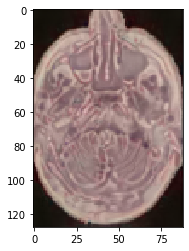

In [14]:
plt.imshow(hints_vol[45,:,:]); plt.show()

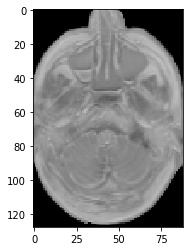

In [15]:
plt.imshow(grey_vol[45,:,:]); plt.show()

### Initialize optimization parameters

#### Parameter for class WindowWidth

In [16]:
wd_width = 1

#### Create weight matrix A and vectors b_u and b_v

In [17]:
pic_size = h*ww*l

channel_Y,_,_ = colorsys.rgb_to_yiq(grey_vol[:,:,:,0],grey_vol[:,:,:,1],grey_vol[:,:,:,2])
_,channel_U,channel_V = colorsys.rgb_to_yiq(hints_vol[:,:,:,0],hints_vol[:,:,:,1],hints_vol[:,:,:,2])

map_colored = (abs(channel_U) + abs(channel_V)) > 0.0001

pic_yuv = np.zeros((h,ww,l,3))
pic_yuv[:,:,:,0] = channel_Y
pic_yuv[:,:,:,1] = channel_U
pic_yuv[:,:,:,2] = channel_V
weightData = []
num_pixel_bw = 0

for i in tqdm.trange(h):
    for j in range(ww):
        for k in range(l):
            res = []
            w = WindowNeighbor(wd_width, (i,j,k), pic_yuv)
            if( not map_colored[i,j,k]):
                weights = affinity_a(w)
                for e in weights:
                    weightData.append([w.center, (e[0],e[1],e[2]), e[3]])
            weightData.append([w.center, (w.center[0],w.center[1], w.center[2]), 1.])

100%|██████████| 128/128 [03:19<00:00,  1.56s/it]


In [18]:
sp_idx_rc_data = [[to_seq(e[0][0],e[0][1],e[0][2],grey_vol), to_seq(e[1][0],e[1][1],e[1][2],grey_vol), e[2]] for e in weightData]
sp_idx_rc = np.array(sp_idx_rc_data, dtype=np.integer)[:,0:2]
sp_data = np.array(sp_idx_rc_data, dtype=np.float64)[:,2]

matA = csr_matrix((sp_data, (sp_idx_rc[:,0], sp_idx_rc[:,1])), shape=(pic_size, pic_size))

b_u = np.zeros(pic_size)
b_v = np.zeros(pic_size)
idx_colored = np.nonzero(map_colored.reshape(pic_size, order='C'))

pic_u_flat = pic_yuv[:,:,:,1].reshape(pic_size, order='C')
b_u[idx_colored] = pic_u_flat[idx_colored]

pic_v_flat = pic_yuv[:,:,:,2].reshape(pic_size, order='C')
b_v[idx_colored] = pic_v_flat[idx_colored]

### Run optimization

In [19]:
ansY = pic_yuv[:,:,:,0].reshape(pic_size, order='C')
ansU = solve(matA, b_u, tol=1.0e-10, verb=True)
ansV = solve(matA, b_v, tol=1.0e-10, verb=True)

  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1
    iteration 2
    iteration 3
    iteration 4
    iteration 5
    iteration 6
    iteration 7
    iteration 8
    iteration 9
    iteration 10
  Residuals ||r_k||_M, ||r_0||_M = 4.28e-09, 4.18e+02
  Residual reduction ||r_k||_M/||r_0||_M = 1.02e-11
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1
    iteration 2
    iteration 3
    iteration 4
    iteration 5
    iteration 6
    iteration 7
    iteration 8
    iteration 9
  Residuals ||r_k||_M, ||r_0||_M = 3.58e-08, 4.31e+02
  Residual reduction ||r_k||_M/||r_0||_M = 8.30e-11


In [20]:
pic_ans = yuv_channels_to_rgb(ansY,ansU,ansV, h, ww, l)

In [21]:
sitk.WriteImage(sitk.GetImageFromArray(pic_ans), 't_out.mhd')

# Post processing

In [22]:
pic_ans = sitk.GetArrayFromImage(sitk.ReadImage('./t_out.mhd'))

In [23]:
def post_process(grey_vol, color_vol, offset=10, axis='x'):
    h,ww,l,c = grey_vol.shape
    out_vol = np.zeros((h,ww,l,c))
    out_vol = color_vol.copy()
    
    slices = []
    if(axis=='x'):
        num_hints = h // offset
        for i in range(num_hints):
            slices.append(grey_vol[i*offset,:,:,:])
    elif(axis=='y'):
        num_hints = ww // offset
        for i in range(num_hints):
            slices.append(grey_vol[:,i*offset,:,:])
    else:
        num_hints = l // offset
        for i in range(num_hints):
            slices.append(grey_vol[:,:,i*offset,:])

    for i in tqdm.trange(num_hints):
        if(axis=='x'):
            out_vol[i*offset,:,:,:] = slices[i]
        elif(axis=='y'):
            out_vol[:,i*offset,:,:] = slices[i]
        else:
            out_vol[:,:,i*offset,:] = slices[i]
            
    pic_size = h*ww*l

    channel_Y,_,_ = colorsys.rgb_to_yiq(grey_vol[:,:,:,0],grey_vol[:,:,:,1],grey_vol[:,:,:,2])
    _,channel_U,channel_V = colorsys.rgb_to_yiq(out_vol[:,:,:,0],out_vol[:,:,:,1],out_vol[:,:,:,2])

    map_colored = (abs(channel_U) + abs(channel_V)) > 0.0001

    pic_yuv = np.zeros((h,ww,l,3))
    pic_yuv[:,:,:,0] = channel_Y
    pic_yuv[:,:,:,1] = channel_U
    pic_yuv[:,:,:,2] = channel_V
    weightData = []
    num_pixel_bw = 0

    for i in tqdm.trange(h):
        for j in range(ww):
            for k in range(l):
                res = []
                w = WindowNeighbor(wd_width, (i,j,k), pic_yuv)
                if( not map_colored[i,j,k]):
                    weights = affinity_a(w)
                    for e in weights:
                        weightData.append([w.center, (e[0],e[1],e[2]), e[3]])
                weightData.append([w.center, (w.center[0],w.center[1], w.center[2]), 1.])
                
    sp_idx_rc_data = [[to_seq(e[0][0],e[0][1],e[0][2],grey_vol), to_seq(e[1][0],e[1][1],e[1][2],grey_vol), e[2]] for e in weightData]
    sp_idx_rc = np.array(sp_idx_rc_data, dtype=np.integer)[:,0:2]
    sp_data = np.array(sp_idx_rc_data, dtype=np.float64)[:,2]

    matA = csr_matrix((sp_data, (sp_idx_rc[:,0], sp_idx_rc[:,1])), shape=(pic_size, pic_size))

    b_u = np.zeros(pic_size)
    b_v = np.zeros(pic_size)
    idx_colored = np.nonzero(map_colored.reshape(pic_size, order='C'))

    pic_u_flat = pic_yuv[:,:,:,1].reshape(pic_size, order='C')
    b_u[idx_colored] = pic_u_flat[idx_colored]

    pic_v_flat = pic_yuv[:,:,:,2].reshape(pic_size, order='C')
    b_v[idx_colored] = pic_v_flat[idx_colored]
    
    ansY = pic_yuv[:,:,:,0].reshape(pic_size, order='C')
    ansU = solve(matA, b_u, tol=1.0e-10, verb=False)
    ansV = solve(matA, b_v, tol=1.0e-10, verb=False)

    out_vol = yuv_channels_to_rgb(ansY,ansU,ansV, h, ww, l)
    
    return out_vol

In [24]:
post_processed_vol = post_process(grey_vol, pic_ans, off, ax)

100%|██████████| 128/128 [01:16<00:00,  1.67it/s]


### Save the generated volume

In [25]:
sitk.WriteImage(sitk.GetImageFromArray(post_processed_vol), OUTPUT_DIR+'post_process_1.mhd')

# Final Generated Volume

In [26]:
sitk.WriteImage(sitk.GetImageFromArray(exposure.adjust_gamma(post_processed_vol, 1.5)), 
                OUTPUT_DIR+'final_output.mhd')